In [2]:
import os
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import sys
sys.path.append(r'C:\Users\tacuevas\Documents\GitHub\concorde\modules')
from mda import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from scipy.spatial import ConvexHull
from shapely.geometry import Point

In [3]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

#### MDA

In [4]:
# df = pd.read_pickle(r'T:\Projects\2016-2020-DHS-CRCoE\Tomas\Thesis\data\STORM\processed\STORM_NA_R3_In_pnt_v5.pkl')
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6.pkl')
df.index = df['tc_number']
df = df.drop(['year', 'yr_tc_number', 'tc_number', 'max_cat'], axis = 1)
df.head()

,month,time_step_at_min_press,time_step_at_min_distNC,lat_at_min_press,lon_at_min_press,lat_at_min_distNC,lon_at_min_distNC,min_press_at_min_distNC,min_press_at_min_press,max_ws_at_min_distNC,...,distNC_at_min_press,trajectory_at_min_distNC,trajectory_at_min_press,trajectory_in_roi,mean_trajectory_roi,mean_curvature_roi,duration,lat_gen,lon_gen,length
tc_number,,,,,,,,,,,,,,,,,,,,,
4.0,11.0,25.0,33.0,29.6,-76.2,30.5,-79.3,977.2,953.7,36.800000,...,623.563360,284.036243,303.690068,296.565051,292.177570,0.463969,141,22.1,-67.9,1895.686058
12.0,8.0,39.0,36.0,31.1,-82.9,29.8,-78.4,956.3,945.0,46.100000,...,728.173029,284.931417,284.036243,288.434949,287.267267,0.019516,132,15.6,-46.8,4740.181192
13.0,9.0,42.0,61.0,29.2,-61.6,37.7,-74.3,980.8,939.8,31.600000,...,1577.689303,304.992020,284.036243,304.992020,305.119842,0.033054,204,14.7,-32.3,5644.897592
27.0,6.0,10.0,6.0,31.6,-73.4,31.1,-76.2,992.6,990.8,22.500000,...,509.300366,81.869898,90.000000,80.537678,79.721465,0.068263,57,30.3,-79.8,1219.021179
33.0,9.0,16.0,72.0,16.1,-49.4,34.8,-79.4,1000.5,951.4,17.525551,...,3449.683632,336.801409,296.565051,345.963757,338.058642,0.068810,219,11.7,-34.3,5914.717493


###### Exploring

In [5]:
dfplot = df.copy()
for col in dfplot.columns:
    if 'trajectory' in col:
        dfplot[col] = [x + 180 if x < 180 else x for x in dfplot[col].values]

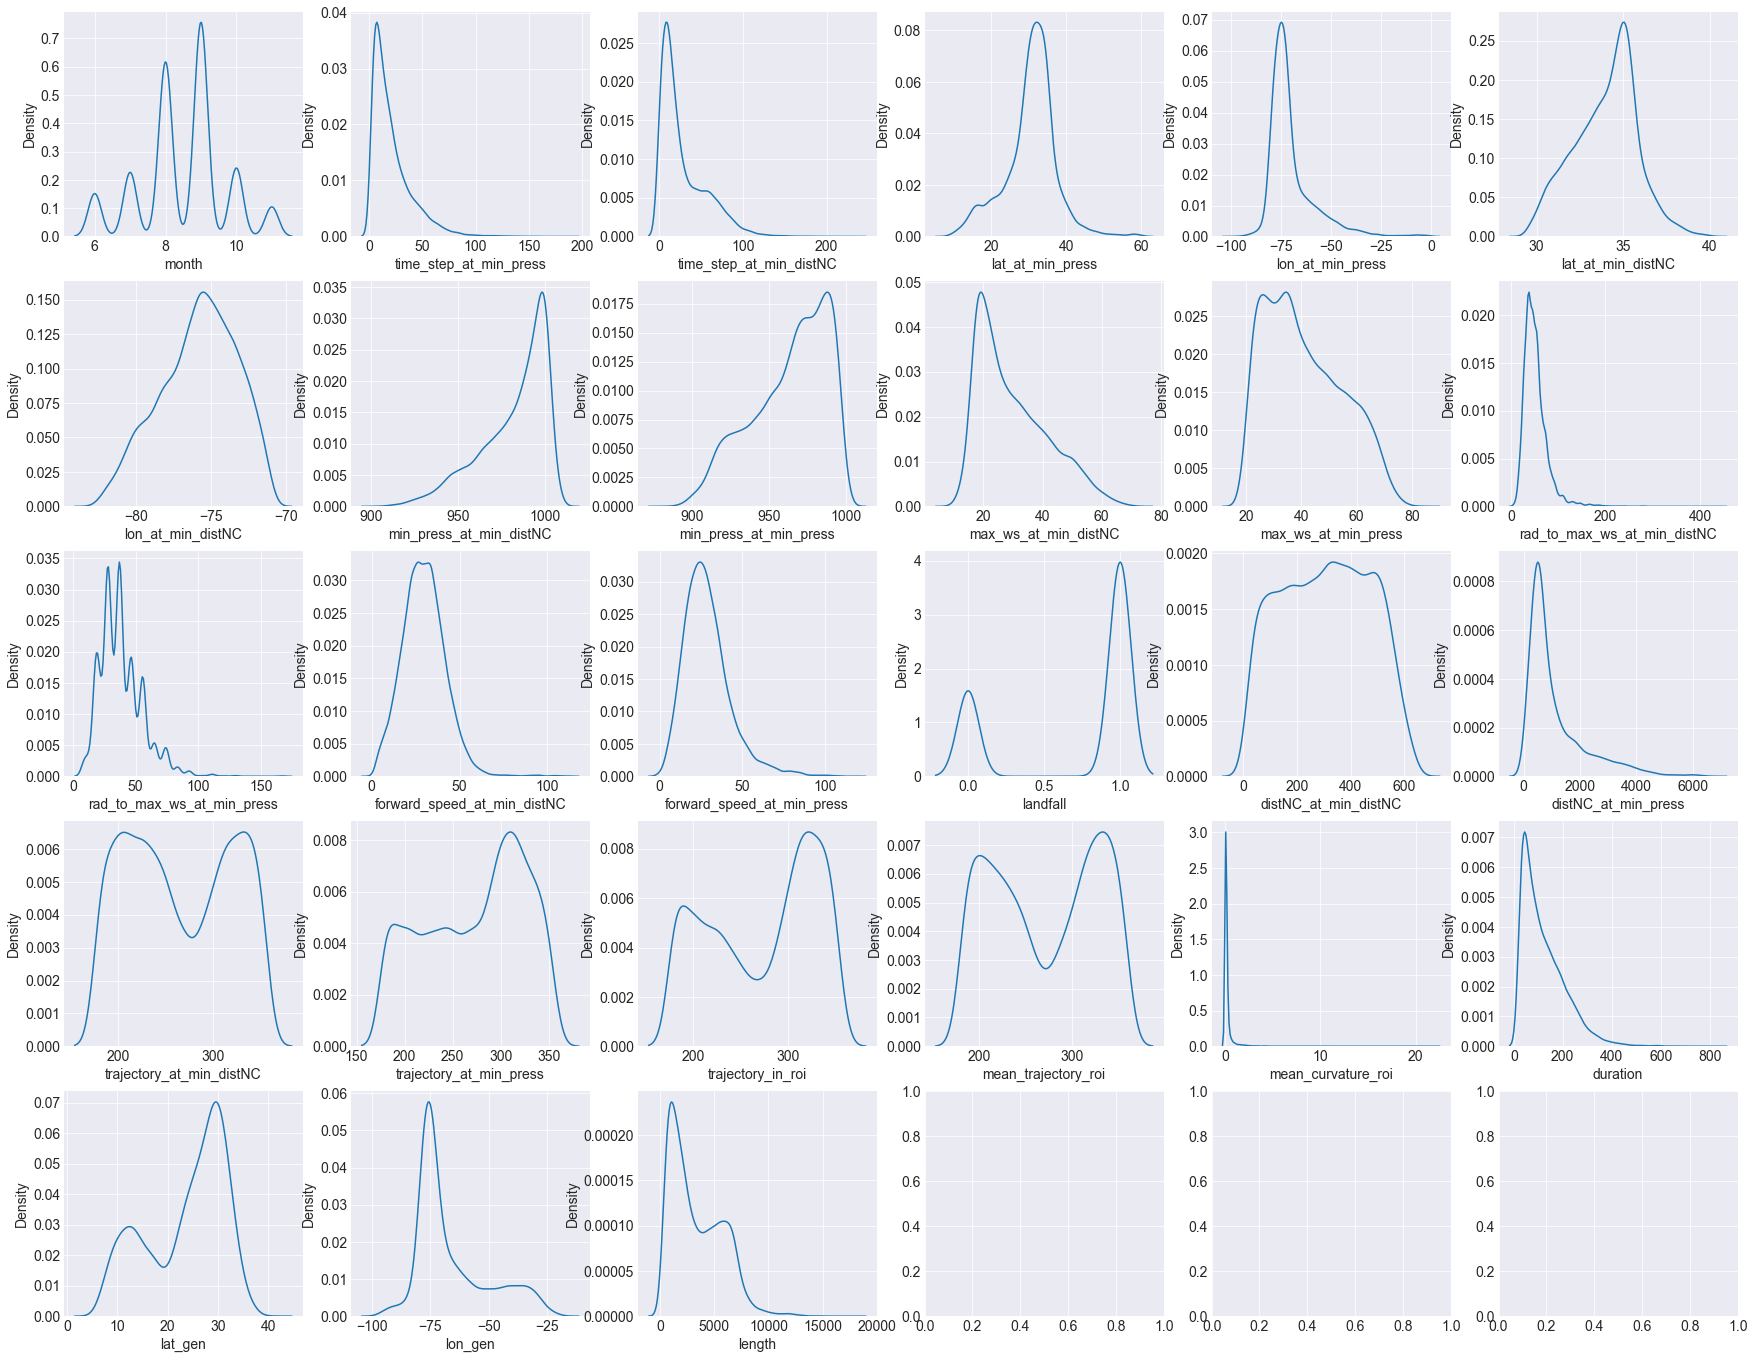

In [6]:
fig, ax = plt.subplots(figsize = (30, 24), nrows = 5, ncols = 6)
for i, j in enumerate(dfplot.columns):
    iax = ax.flatten()[i]
    sns.distplot(a = dfplot[j], ax = iax, hist = False)

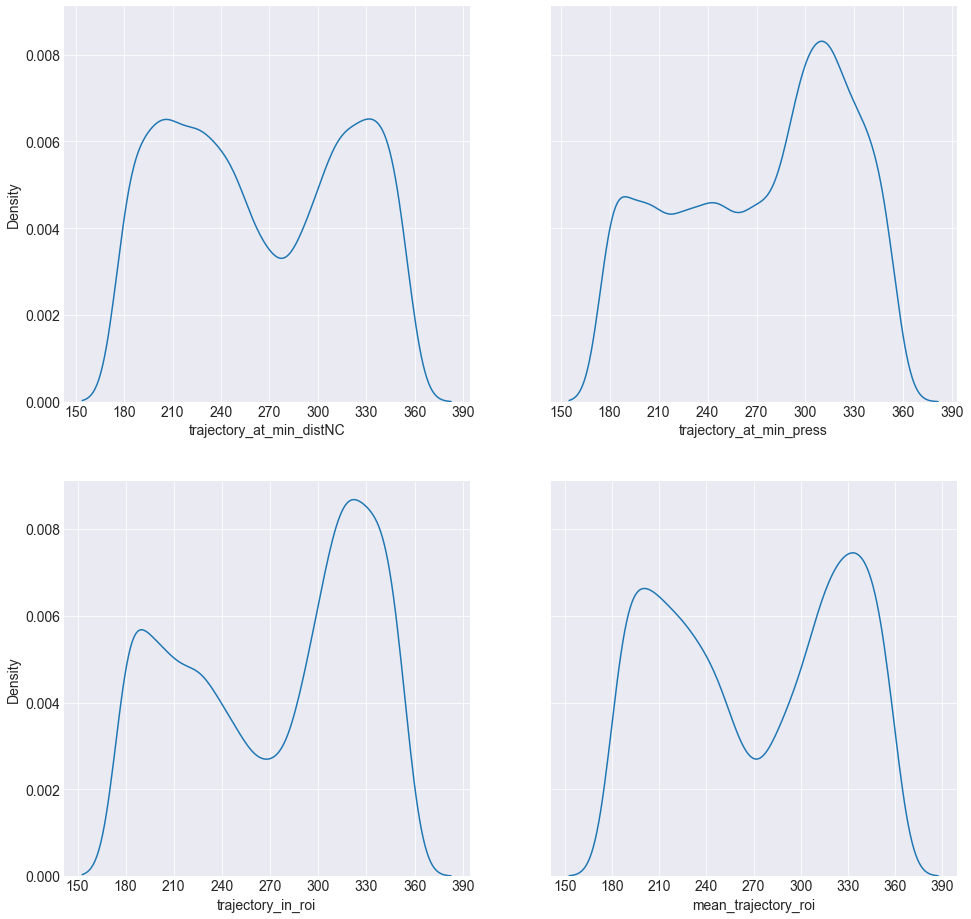

In [8]:
fig, ax = plt.subplots(figsize = (16, 16), nrows = 2, ncols = 2, sharey = True)
i = 0
for col in dfplot.columns:
    if 'trajectory' in col:
        iax = ax.flatten()[i]
        sns.distplot(a = dfplot[col], ax = iax, hist = False)
        i += 1
        iax.set_xticks(np.arange(150, 420, 30))

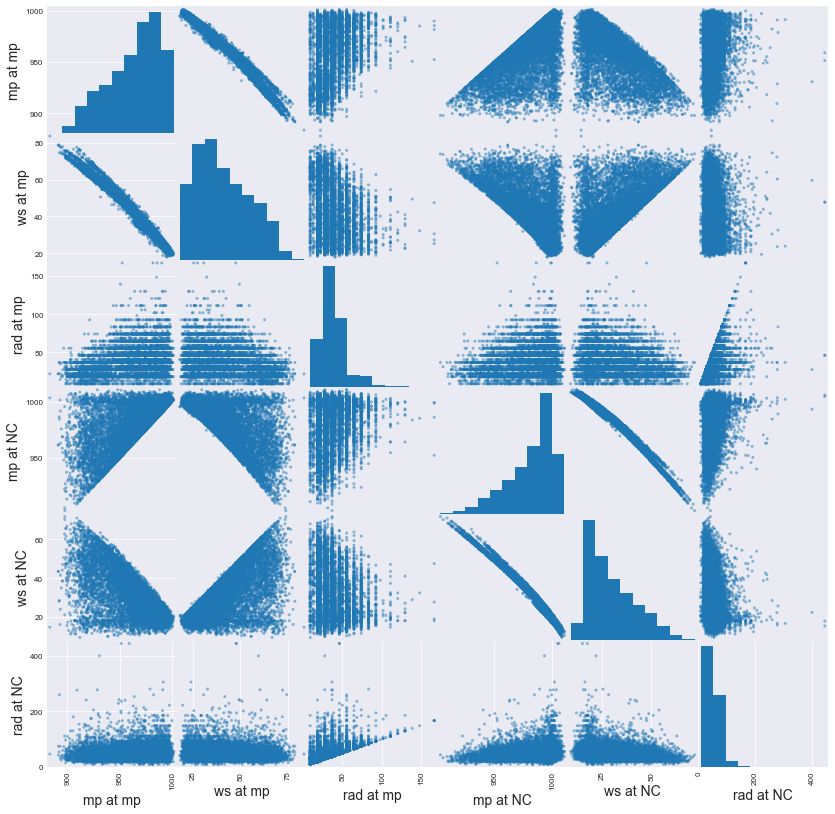

In [18]:
dummy = df[['min_press_at_min_press', 'max_ws_at_min_press', 'rad_to_max_ws_at_min_press', 'min_press_at_min_distNC', 'max_ws_at_min_distNC', 'rad_to_max_ws_at_min_distNC']]
dummy.columns = ['mp at mp', 'ws at mp', 'rad at mp', 'mp at NC', 'ws at NC', 'rad at NC']
fig, ax = plt.subplots(figsize = (14, 14))
pd.plotting.scatter_matrix(dummy, ax = ax);

<AxesSubplot:xlabel='length', ylabel='duration'>

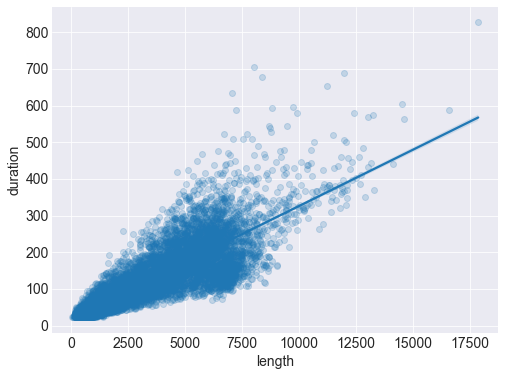

In [19]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.regplot(x = df['length'], y = df['duration'], ax = ax, scatter_kws={'alpha':0.2})

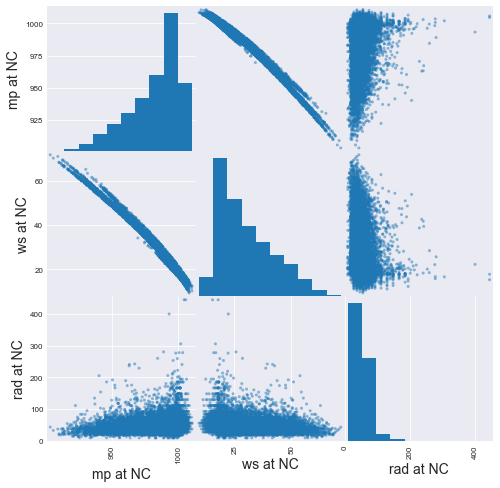

In [20]:
dummy = df[['min_press_at_min_distNC', 'max_ws_at_min_distNC', 'rad_to_max_ws_at_min_distNC']]
dummy.columns = ['mp at NC', 'ws at NC', 'rad at NC']
fig, ax = plt.subplots(figsize = (8, 8))
pd.plotting.scatter_matrix(dummy, ax = ax);

<AxesSubplot:>

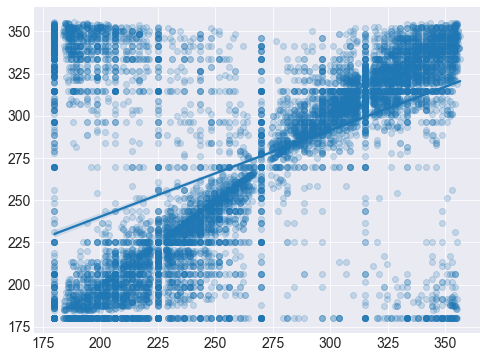

In [23]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.regplot(x = [x + 180 if x < 180 else x for x in df['trajectory_at_min_distNC']], 
            y = [x + 180 if x < 180 else x for x in df['trajectory_in_roi']], ax = ax, scatter_kws={'alpha':0.2})

In [24]:
## using month
dfr = df.drop(['time_step_at_min_press', 'time_step_at_min_distNC', 'lat_at_min_press', 'lon_at_min_press', 'min_press_at_min_press', 'max_ws_at_min_press',
             'rad_to_max_ws_at_min_press', 'forward_speed_at_min_press', 'distNC_at_min_press', 'trajectory_at_min_press', 'max_ws_at_min_distNC', 
               'trajectory_at_min_distNC', 'length', 'distNC_at_min_distNC'], axis = 1)
dfr.index = range(len(dfr))
print(len(dfr.columns))

13


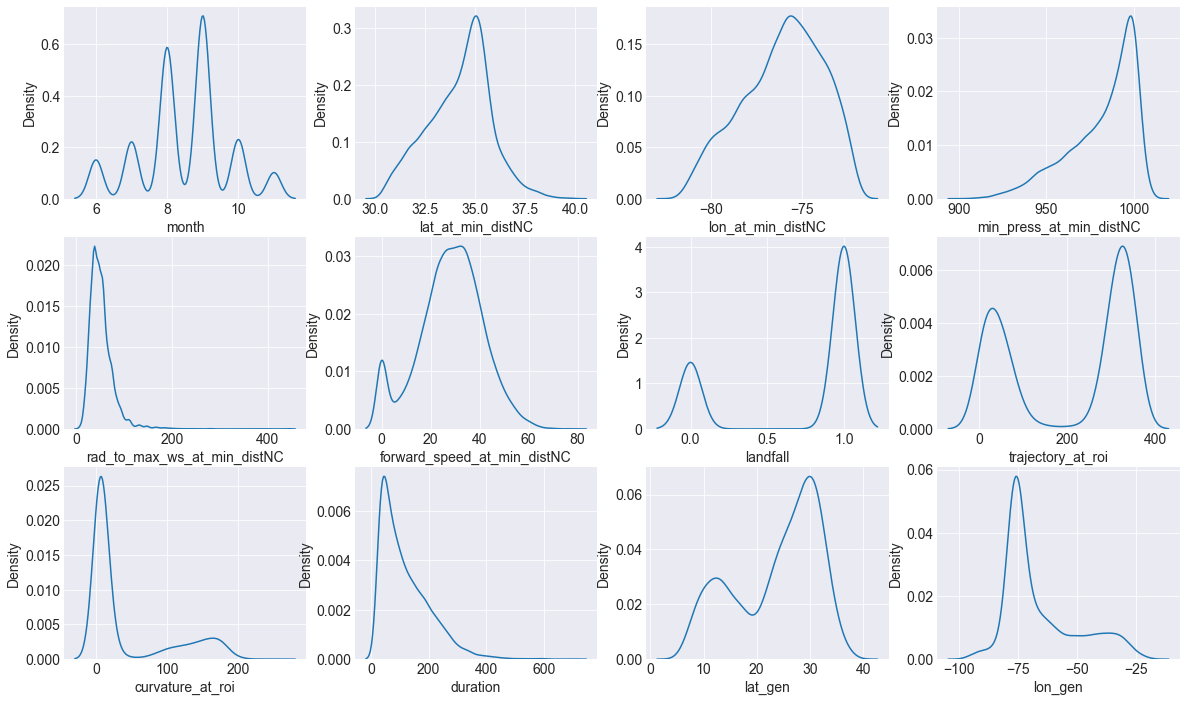

In [13]:
fig, ax = plt.subplots(figsize = (20, 12), nrows = 3, ncols = 4)
for i, j in enumerate(dfr.columns):
    iax = ax.flatten()[i]
    sns.distplot(a = dfr[j], ax = iax, hist = False)

In [26]:
dfr.describe().T

,count,mean,std,min,25%,50%,75%,max
month,9901.0,8.488234,1.195187,6.00,8.000000,9.000000,9.000000,11.000000
lat_at_min_distNC,9901.0,33.982224,1.824517,29.30,32.700000,34.300000,35.200000,40.100000
lon_at_min_distNC,9901.0,-75.827169,2.549720,-82.90,-77.600000,-75.600000,-73.900000,-70.800000
min_press_at_min_distNC,9901.0,982.083775,19.255035,903.50,970.800000,988.000000,997.400000,1010.400000
rad_to_max_ws_at_min_distNC,9901.0,51.758508,25.882789,9.26,37.040001,46.299999,61.116000,444.480011
forward_speed_at_min_distNC,9901.0,29.665913,12.164440,0.00,21.908456,29.472852,37.103350,112.175674
landfall,9901.0,0.714675,0.451592,0.00,0.000000,1.000000,1.000000,1.000000
trajectory_in_roi,9901.0,194.178359,141.487533,0.00,39.805571,286.699244,323.130102,355.601295
mean_trajectory_roi,9901.0,180.861320,142.242196,0.00,37.624867,163.957350,324.336033,360.000000
mean_curvature_roi,9901.0,0.219925,0.594751,0.00,0.043576,0.084330,0.171813,22.260593


In [31]:
index0 = [0 if 'trajectory' in x else 0 for x in dfr.columns]
cl0 = anti_neighbors_vectorized(dfr, 1000, index0)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:23<00:00, 41.98it/s]


In [32]:
index1 = [0 if 'trajectory' in x else 0 for x in dfr.columns[1:]]
cl1 = anti_neighbors_vectorized(dfr.iloc[:, 1:], 1000, index1)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:24<00:00, 41.44it/s]


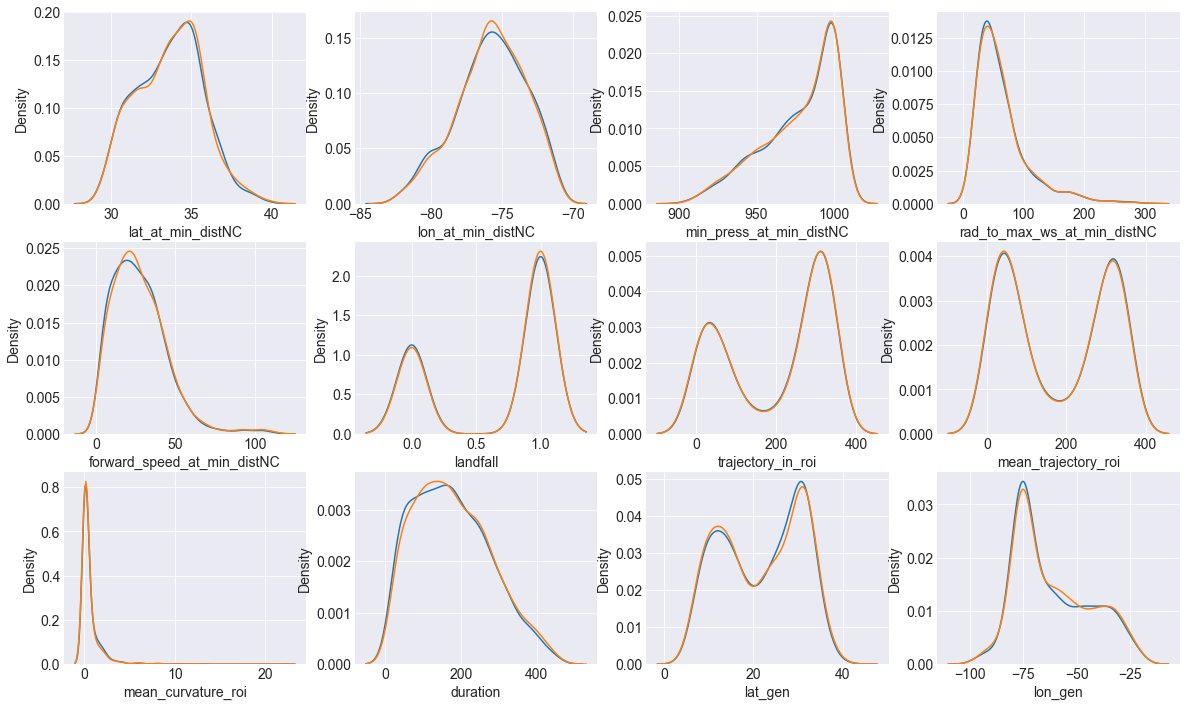

In [35]:
fig, ax = plt.subplots(figsize = (20, 12), nrows = 3, ncols = 4)
for i, j in enumerate(cl1.columns[:-2]):
    iax = ax.flatten()[i]
    sns.distplot(a = cl0[j], ax = iax, hist = False)
    sns.distplot(a = cl1[j], ax = iax, hist = False)

In [ ]:
## month wont be considered since the distribution doesn't change much

In [62]:
index1 = [0 if 'trajectory' in x else 0 for x in dfr.columns[1:]]
cl2 = anti_neighbors_vectorized(dfr[dfr['mean_curvature_roi'] < dfr['mean_curvature_roi'].quantile(0.995)].iloc[:, 1:], 1000, index1)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:24<00:00, 40.01it/s]


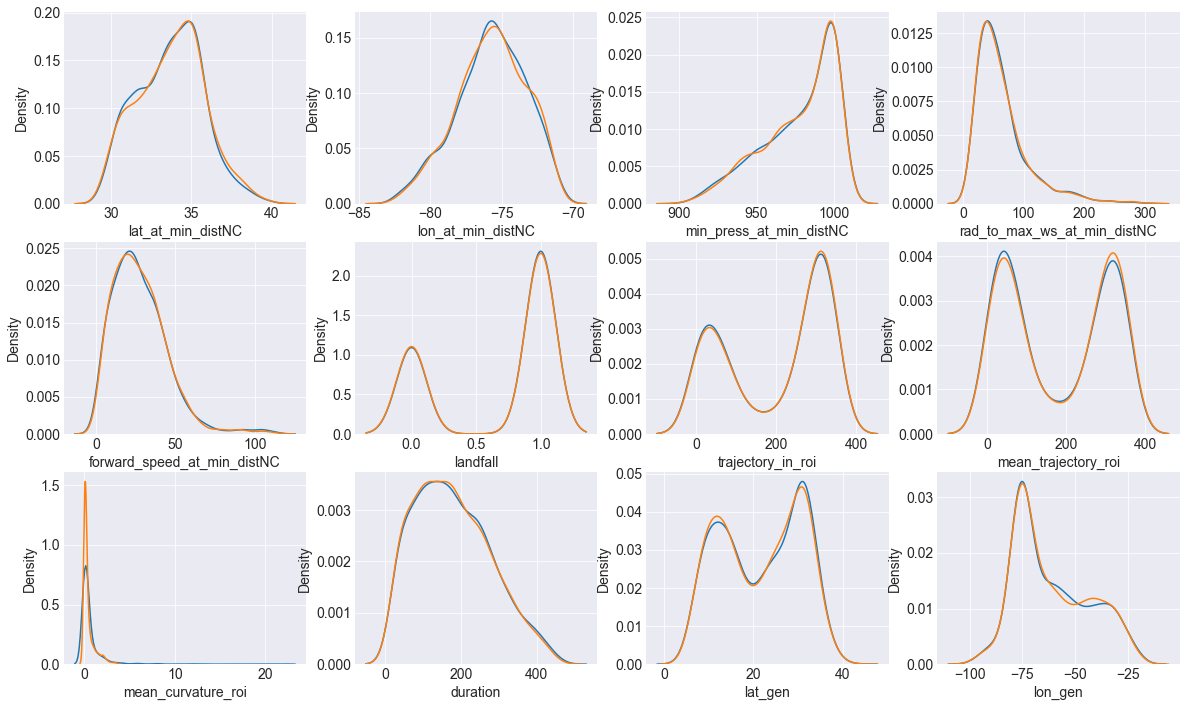

In [63]:
fig, ax = plt.subplots(figsize = (20, 12), nrows = 3, ncols = 4)
for i, j in enumerate(cl1.columns[:-2]):
    iax = ax.flatten()[i]
    sns.distplot(a = cl1[j], ax = iax, hist = False)
    sns.distplot(a = cl2[j], ax = iax, hist = False)

In [64]:
index1 = [0 if 'trajectory' in x else 0 for x in dfr.columns[1:]]
cl3 = anti_neighbors_vectorized(dfr[dfr['rad_to_max_ws_at_min_distNC'] < dfr['rad_to_max_ws_at_min_distNC'].quantile(0.995)].iloc[:, 1:], 1000, index1)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:22<00:00, 44.39it/s]


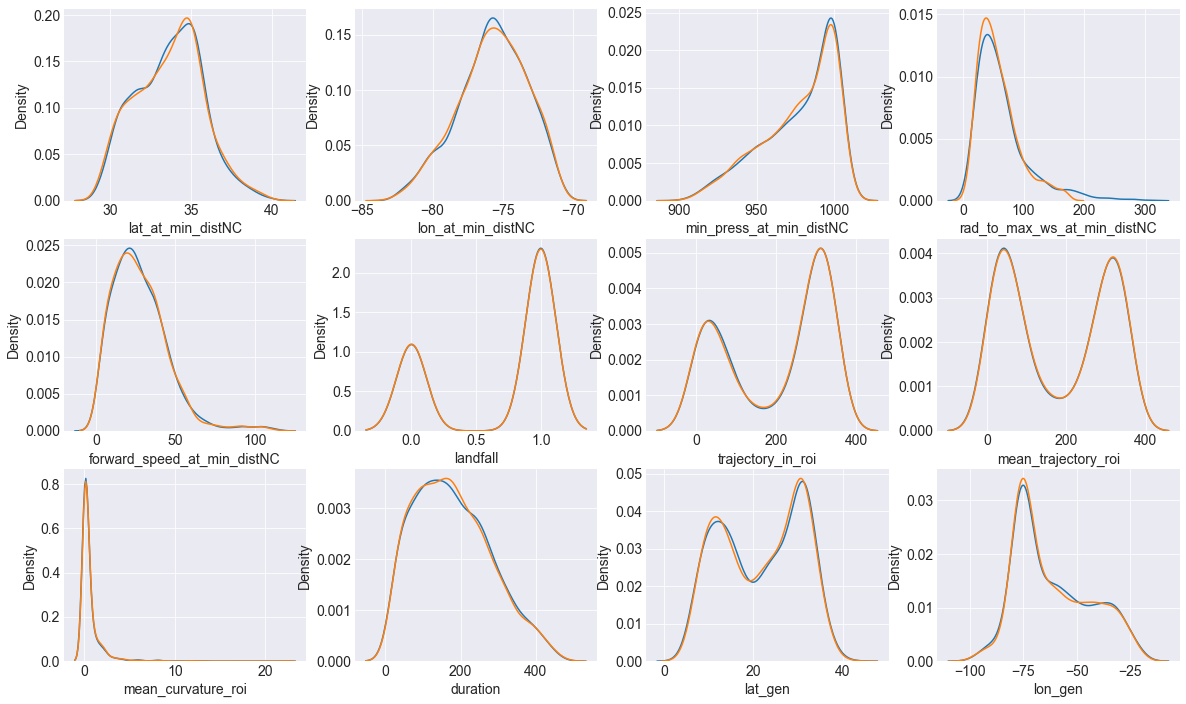

In [65]:
fig, ax = plt.subplots(figsize = (20, 12), nrows = 3, ncols = 4)
for i, j in enumerate(cl1.columns[:-2]):
    iax = ax.flatten()[i]
    sns.distplot(a = cl1[j], ax = iax, hist = False)
    sns.distplot(a = cl3[j], ax = iax, hist = False)

In [ ]:
dfall = pd.read_pickle(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_InOut_v6.pkl")

In [ ]:
df[df['mean_curvature_roi'] > 20]

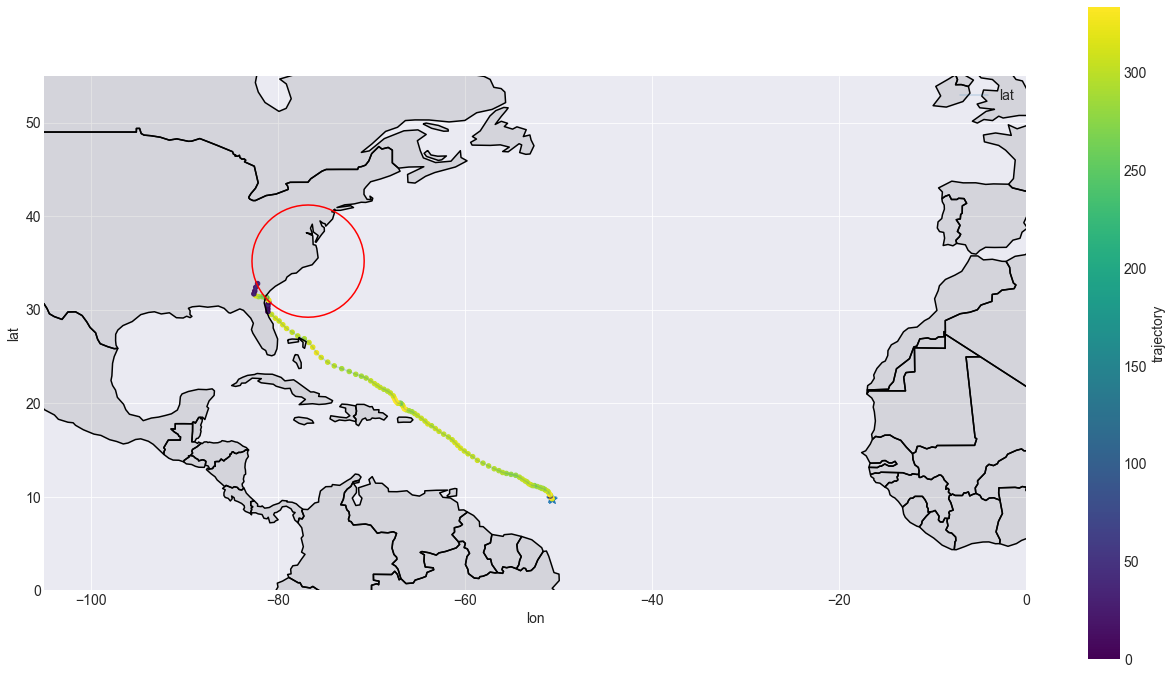

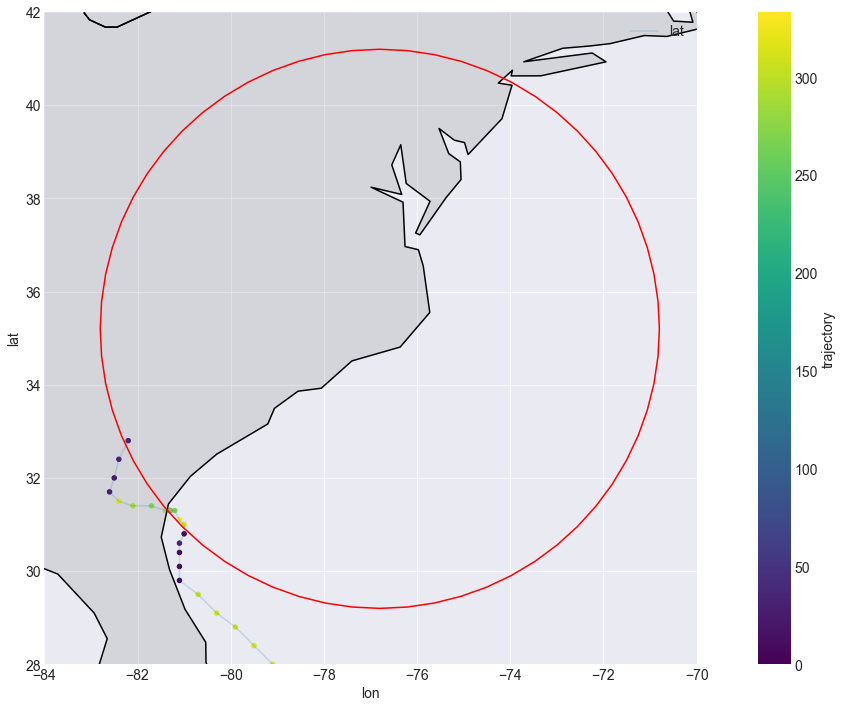

In [51]:
dfworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
dfsub = dfall[dfall['tc_number'] == 91419]
nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

fig, ax = plt.subplots(figsize = (22, 12))
dfworld.plot(ax = ax, color = 'grey', alpha = 0.2)
dfworld.boundary.plot(ax = ax, color = 'k')
dfsub.iloc[:2, :].plot.scatter(x = 'lon', y = 'lat', ax = ax, marker = '*', s = 100)
dfsub.plot.scatter(x = 'lon', y = 'lat', ax = ax, c = 'trajectory', cmap = 'viridis')
dfsub.plot(x = 'lon', y = 'lat', ax = ax, alpha = 0.2)

box.boundary.plot(ax = ax, color = 'r')
ax.set_xlim([-105, 0])
ax.set_ylim([0, 55])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize = (22, 12))
dfworld.plot(ax = ax, color = 'grey', alpha = 0.2)
dfworld.boundary.plot(ax = ax, color = 'k')
dfsub.iloc[:2, :].plot.scatter(x = 'lon', y = 'lat', ax = ax, marker = '*', s = 100)
dfsub.plot.scatter(x = 'lon', y = 'lat', ax = ax, c = 'trajectory', cmap = 'viridis')
dfsub.plot(x = 'lon', y = 'lat', ax = ax, alpha = 0.2)

box.boundary.plot(ax = ax, color = 'r')
ax.set_xlim([-84, -70])
ax.set_ylim([28, 42])
ax.set_aspect('equal')

###### Production

In [4]:
# df = pd.read_pickle(r'T:\Projects\2016-2020-DHS-CRCoE\Tomas\Thesis\data\STORM\processed\STORM_NA_R3_In_pnt_v5.pkl')
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6.pkl')
df = df[df['rad_to_max_ws_at_min_distNC'] < df['rad_to_max_ws_at_min_distNC'].quantile(0.995)]
df = df[df['mean_curvature_roi'] < df['mean_curvature_roi'].quantile(0.995)]

df.index = df['tc_number']
dfr = df.drop(['year', 'yr_tc_number', 'tc_number', 'max_cat', 'time_step_at_min_press', 'time_step_at_min_distNC', 'lat_at_min_press', 'lon_at_min_press', 'min_press_at_min_press', 'max_ws_at_min_press',
             'rad_to_max_ws_at_min_press', 'forward_speed_at_min_press', 'distNC_at_min_press', 'trajectory_at_min_press', 'max_ws_at_min_distNC', 
               'trajectory_at_min_distNC', 'length', 'distNC_at_min_distNC', 'month'], axis = 1)

dfr.index = range(len(dfr))
print(len(dfr.columns))
dfr.describe().T

12


,count,mean,std,min,25%,50%,75%,max
lat_at_min_distNC,9801.0,33.991297,1.819349,29.30,32.700000,34.300000,35.200000,40.100000
lon_at_min_distNC,9801.0,-75.825712,2.549961,-82.90,-77.600000,-75.600000,-73.900000,-70.800000
min_press_at_min_distNC,9801.0,982.032568,19.247626,903.50,970.800000,987.900000,997.400000,1010.400000
rad_to_max_ws_at_min_distNC,9801.0,50.913581,22.447603,9.26,37.040001,46.299999,60.546154,173.955712
forward_speed_at_min_distNC,9801.0,29.765535,12.085679,0.00,22.045141,29.581237,37.104259,112.175674
landfall,9801.0,0.717274,0.450347,0.00,0.000000,1.000000,1.000000,1.000000
trajectory_in_roi,9801.0,194.237905,141.581909,0.00,39.805571,288.434949,323.130102,355.601295
mean_trajectory_roi,9801.0,181.009949,142.370613,0.00,37.565700,166.829696,324.456228,360.000000
mean_curvature_roi,9801.0,0.190327,0.357815,0.00,0.043466,0.083855,0.168760,3.572465
duration,9801.0,121.499541,87.371327,24.00,51.000000,99.000000,171.000000,828.000000


In [8]:
index = [0 if 'trajectory' in x else 0 for x in dfr.columns]

In [9]:
cl = anti_neighbors_vectorized(dfr, 1_000, index)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:17<00:00, 58.46it/s]


In [12]:
dfr['tc_number'] = df.index

In [17]:
dfr.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6_inpMDA.pkl')

In [19]:
cl['tc_number'] = df.iloc[cl['index_cluster'], :].index

In [20]:
cl.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6_Clusters_MDAvec_12params_1000.pkl')

In [8]:
dct_cls = {'dfs':[], 'max_nclusters': [], 'min_nclusters':[], 'n':[]}
for n in range(250, 1050, 50):
    cl = anti_neighbors_vectorized(dfr, n, index)
    dct_cls['dfs'].append(cl)
    dct_cls['max_nclusters'].append(cl['npoints'].max())
    dct_cls['min_nclusters'].append(cl['npoints'].min())
    dct_cls['n'].append(n)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:16<00:00, 59.71it/s]


In [9]:
dfnclusters = pd.DataFrame()
for x, n in zip(dct_cls['dfs'], dct_cls['n']):
    vals = list(x['npoints'].values)
    if n < 1000:
        dummy = [np.nan]*(1000 - n)
        vals.extend(dummy)
    dfnclusters[n] = vals

Text(0, 0.5, 'Number of cases per cluster [-]')

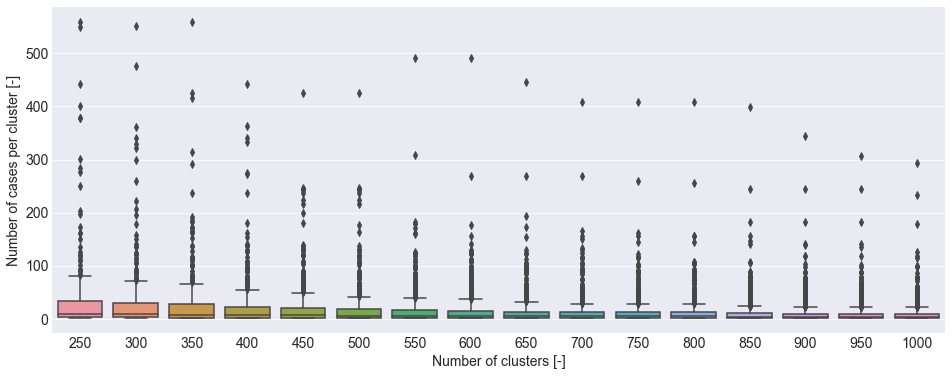

In [10]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.boxplot(data = dfnclusters, ax = ax)
ax.set_xlabel('Number of clusters [-]')
ax.set_ylabel('Number of cases per cluster [-]')

In [27]:
l = []
for x, n in zip(dct_cls['dfs'], dct_cls['n']):
    a = x[x['npoints'] > 200]
    l.append(a)
    print(f'Total num clusters: {len(x)} - n clusters with more than 200 points: {len(a)}')

Total num clusters: 250 - n clusters with more than 200 points: 11
Total num clusters: 300 - n clusters with more than 200 points: 10
Total num clusters: 350 - n clusters with more than 200 points: 6
Total num clusters: 400 - n clusters with more than 200 points: 7
Total num clusters: 450 - n clusters with more than 200 points: 7
Total num clusters: 500 - n clusters with more than 200 points: 7
Total num clusters: 550 - n clusters with more than 200 points: 2
Total num clusters: 600 - n clusters with more than 200 points: 2
Total num clusters: 650 - n clusters with more than 200 points: 2
Total num clusters: 700 - n clusters with more than 200 points: 2
Total num clusters: 750 - n clusters with more than 200 points: 2
Total num clusters: 800 - n clusters with more than 200 points: 2
Total num clusters: 850 - n clusters with more than 200 points: 2
Total num clusters: 900 - n clusters with more than 200 points: 2
Total num clusters: 950 - n clusters with more than 200 points: 2
Total nu

In [41]:
l = []
for x, n in zip(dct_cls['dfs'], dct_cls['n']):
    a = x['npoints'].max()
    b = x['npoints'].idxmax()
    print(f'Cluster with max points: {b} - {a} ({len(x)})')

Cluster with max points: 4 - 558 (250)
Cluster with max points: 4 - 551 (300)
Cluster with max points: 318 - 559 (350)
Cluster with max points: 351 - 442 (400)
Cluster with max points: 351 - 426 (450)
Cluster with max points: 351 - 426 (500)
Cluster with max points: 514 - 492 (550)
Cluster with max points: 514 - 492 (600)
Cluster with max points: 514 - 446 (650)
Cluster with max points: 514 - 409 (700)
Cluster with max points: 514 - 409 (750)
Cluster with max points: 514 - 409 (800)
Cluster with max points: 514 - 399 (850)
Cluster with max points: 514 - 344 (900)
Cluster with max points: 514 - 307 (950)
Cluster with max points: 514 - 294 (1000)


In [43]:
dfpnt = dct_cls['dfs'][-1].copy()

In [34]:
dfpnt.describe().T

,count,mean,std,min,25%,50%,75%,max
lat_at_min_distNC,250.0,33.416800,1.995909,29.500000,31.900000,33.500000,34.900000,38.800000
lon_at_min_distNC,250.0,-75.660800,2.464915,-81.800000,-77.375000,-75.700000,-73.700000,-71.100000
min_press_at_min_distNC,250.0,977.564779,24.570754,903.500000,960.225000,985.650000,998.570503,1007.000000
rad_to_max_ws_at_min_distNC,250.0,63.108496,37.411220,10.803333,34.325136,54.190292,82.059938,173.955712
forward_speed_at_min_distNC,250.0,27.670957,20.937597,2.970937,12.662172,23.005964,37.383815,112.175674
landfall,250.0,0.688000,0.464239,0.000000,0.000000,1.000000,1.000000,1.000000
trajectory_in_roi,250.0,190.055526,121.865941,0.000000,63.434949,242.567097,299.572312,354.289407
mean_trajectory_roi,250.0,169.136885,123.448008,0.336886,55.575014,144.171250,292.867901,358.513245
mean_curvature_roi,250.0,0.611144,0.798200,0.000000,0.075290,0.228002,0.872323,3.545342
duration,250.0,192.132000,104.257879,24.000000,105.750000,177.000000,271.500000,441.000000


Text(0, 0.5, 'rad_to_max_ws_at_min_distNC')

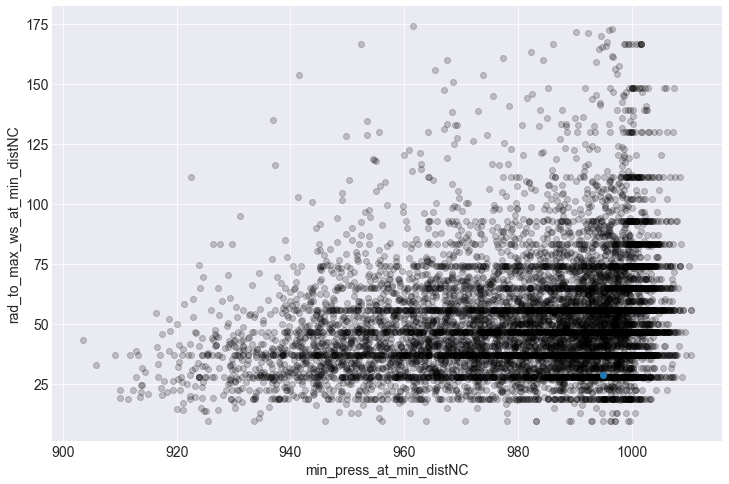

In [47]:
x = 'min_press_at_min_distNC'
y = 'rad_to_max_ws_at_min_distNC'
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(dfr[x], dfr[y], alpha = 0.2, c = 'k')
ax.scatter(dfpnt.loc[514, x], dfpnt.loc[4, y])
ax.set_xlabel(x)
ax.set_ylabel(y)

Text(0, 0.5, 'lat_at_min_distNC')

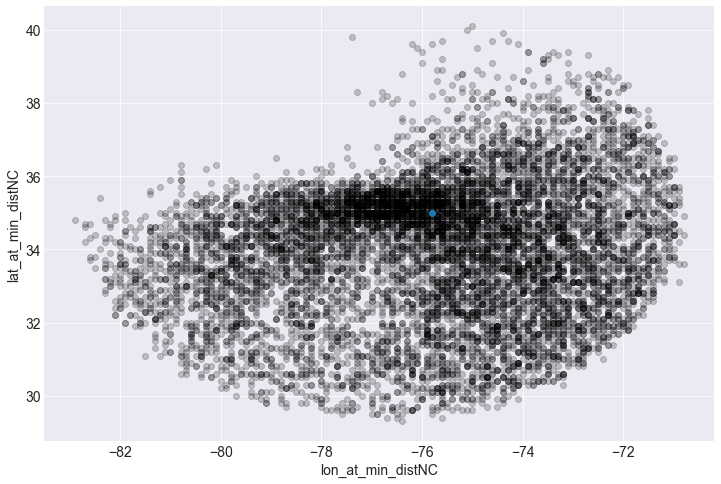

In [48]:
x = 'lon_at_min_distNC'
y = 'lat_at_min_distNC'
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(dfr[x], dfr[y], alpha = 0.2, c = 'k')
ax.scatter(dfpnt.loc[514, x], dfpnt.loc[4, y])
ax.set_xlabel(x)
ax.set_ylabel(y)

Text(0, 0.5, 'forward_speed_at_min_distNC')

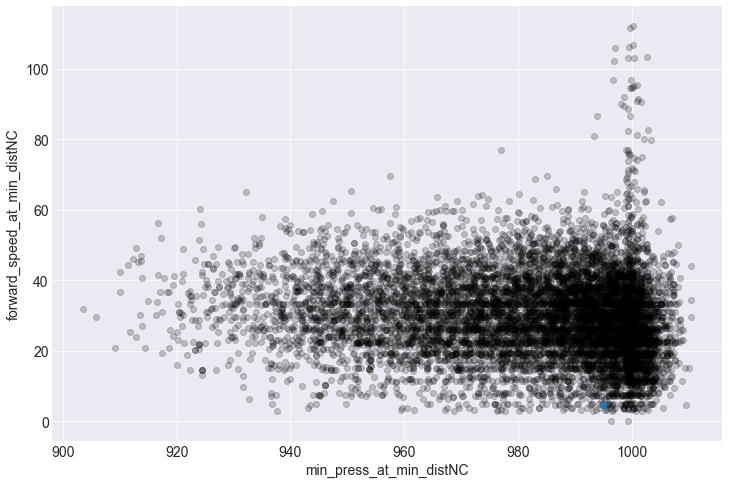

In [49]:
x = 'min_press_at_min_distNC'
y = 'forward_speed_at_min_distNC'
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(dfr[x], dfr[y], alpha = 0.2, c = 'k')
ax.scatter(dfpnt.loc[514, x], dfpnt.loc[4, y])
ax.set_xlabel(x)
ax.set_ylabel(y)

In [21]:
with open(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6_Clusters_MDAvec_12params_dict.pkl', 'wb') as fout:
    pickle.dump(dct_cls, fout)